In [63]:
import numpy as np
from scipy.stats import poisson, beta, lognorm

# Parâmetros por tranche
tranches = [
    {"n": 50, "p": 0.03, "mu_rec": 0.4, "sigma_rec": 0.1, "mu_L": 1000, "sigma_L": 300, "mu_T": 5, "sigma_T": 1},  # Tranche 1
    {"n": 30, "p": 0.05, "mu_rec": 0.5, "sigma_rec": 0.15, "mu_L": 2000, "sigma_L": 600, "mu_T": 7, "sigma_T": 2}, # Tranche 2
    {"n": 20, "p": 0.08, "mu_rec": 0.6, "sigma_rec": 0.2, "mu_L": 500, "sigma_L": 150, "mu_T": 3, "sigma_T": 0.5},  # Tranche 3
]

simulations = 1000  # Número de simulações
r = 0.05  # Taxa de desconto anual
j = 0.1   # Taxa de juros anual dos empréstimos
max_years = 10  # Período máximo de análise (horizonte)

# Função para calcular alpha e beta da distribuição Beta
def beta_params(mean, var):
    alpha = mean * ((mean * (1 - mean) / var) - 1)
    beta = (1 - mean) * ((mean * (1 - mean) / var) - 1)
    return alpha, beta

# Função para calcular os parâmetros da lognormal
def lognormal_params(mean, std):
    var = std**2
    mu = np.log(mean**2 / np.sqrt(var + mean**2))
    sigma = np.sqrt(np.log(1 + var / mean**2))
    return mu, sigma

# Simulação Monte Carlo
all_cashflows = []
all_losses = []

for _ in range(simulations):
    annual_cashflows = np.zeros(max_years)  # Fluxos anuais da carteira
    anual_loss = np.zeros(max_years)  # Perdas anuais da carteira
    for tranche in tranches:
        # Parâmetros da tranche
        n, p = tranche["n"], tranche["p"]
        mu_rec, sigma_rec = tranche["mu_rec"], tranche["sigma_rec"]
        mu_L, sigma_L = tranche["mu_L"], tranche["sigma_L"]
        mu_T, sigma_T = tranche["mu_T"], tranche["sigma_T"]
        
        # Gerar valores dos empréstimos (Lognormal)
        mu, sigma = lognormal_params(mu_L, sigma_L)
        loan_values = lognorm.rvs(s=sigma, scale=np.exp(mu), size=n)
        
        # Gerar maturidades (Normal truncada)
        maturities = np.clip(np.random.normal(mu_T, sigma_T, n), 1, max_years).astype(int)
        
        # Determinar número de defaults (Poisson)
        lambda_k = n * p
        D_k = poisson.rvs(lambda_k)
        
        # Empréstimos que entram em default
        default_indices = np.random.choice(n, size=D_k, replace=False, p=None)
        alpha_k, beta_k = beta_params(mu_rec, sigma_rec**2)
        recoveries = beta.rvs(alpha_k, beta_k, size=D_k)
        
        for i in default_indices:
            
            L = loan_values[i]
            T_i = maturities[i]
            A = L / T_i
            balance = L
            for t in range(T_i):
                if t >= max_years: break  # Parar se o tempo excede o horizonte de análise

                # Verificar default
                if t == T_i - 1 or np.random.uniform(0, 1) < p:  # Default no período
                    recovery = recoveries[np.where(default_indices == i)[0][0]] * balance
                    annual_cashflows[t] += recovery  # Adicionar recuperação
                    loss = balance - recovery
                    anual_loss[t] += loss
                    break
                else:
                    # Calcular juros e parcela total
                    J_t = balance * j
                    P_t = A + J_t

                    # Adicionar fluxo regular ao ano atual
                    annual_cashflows[t] += P_t

                    # Atualizar saldo devedor
                    balance -= A
        
        # Empréstimos que não entram em default
        non_default_indices = set(range(n)) - set(default_indices)
        for i in non_default_indices:
            L = loan_values[i]
            T_i = maturities[i]
            A = L / T_i
            balance = L
            for t in range(T_i):
                if t >= max_years: break  # Parar se o tempo excede o horizonte de análise
                
                # Calcular juros e parcela total
                J_t = balance * j
                P_t = A + J_t
                
                # Adicionar fluxo regular ao ano atual
                annual_cashflows[t] += P_t
                
                # Atualizar saldo devedor
                balance -= A
    
    all_cashflows.append(annual_cashflows)
    all_losses.append(anual_loss)

# Cálculo do valor esperado dos fluxos por ano
expected_cashflows = np.mean(all_cashflows, axis=0)

#Calculo da expectativa de perda
expected_loss = np.mean(all_losses, axis=0)

# Cálculo do valor presente dos fluxos
years = np.arange(1, max_years + 1)
present_value = np.sum(expected_cashflows / (1 + r) ** years)

#Cálculo do VaR95
VaR95 = np.percentile(all_losses, 95, axis=0)

#Cálculo da Expected Shortfall para cada ano
ES = np.zeros(max_years)
for t in range(max_years):
    ES[t] = np.mean([loss for loss in all_losses[0:][t] if loss > VaR95[t]])
    if np.isnan(ES[t]):
        ES[t] = VaR95[t]

# Resultados
print("Fluxos esperados por ano:")
for t, cashflow in enumerate(expected_cashflows, start=1):
    print(f"Ano {t}: {cashflow:.2f}")
    
print(f"\nValor Presente da Carteira: {present_value:.2f}")

print("\nPerdas esperadas por ano:")
for t, loss in enumerate(expected_loss, start=1):
    print(f"Ano {t}: {loss:.2f}")

print(f"\nVaR95: ")
for t, loss in enumerate(VaR95, start=1):
    print(f"Ano {t}: {loss:.2f}")

print("\nExpected Shortfall:")
for t, es in enumerate(ES, start=1):
    print(f"Ano {t}: {es:.2f}")

Fluxos esperados por ano:
Ano 1: 38739.99
Ano 2: 35161.87
Ano 3: 29113.71
Ano 4: 22129.20
Ano 5: 14729.45
Ano 6: 8324.79
Ano 7: 4636.08
Ano 8: 2464.93
Ano 9: 1118.15
Ano 10: 419.90

Valor Presente da Carteira: 135838.03

Perdas esperadas por ano:
Ano 1: 143.91
Ano 2: 174.08
Ano 3: 163.02
Ano 4: 127.68
Ano 5: 110.38
Ano 6: 66.19
Ano 7: 40.00
Ano 8: 19.36
Ano 9: 10.98
Ano 10: 6.82

VaR95: 
Ano 1: 983.04
Ano 2: 794.32
Ano 3: 653.95
Ano 4: 521.13
Ano 5: 445.77
Ano 6: 322.44
Ano 7: 216.55
Ano 8: 136.46
Ano 9: 104.52
Ano 10: 68.47

Expected Shortfall:
Ano 1: 983.04
Ano 2: 794.32
Ano 3: 1272.15
Ano 4: 521.13
Ano 5: 445.77
Ano 6: 322.44
Ano 7: 216.55
Ano 8: 259.28
Ano 9: 136.39
Ano 10: 163.76


c:\Users\d805664\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\d805664\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


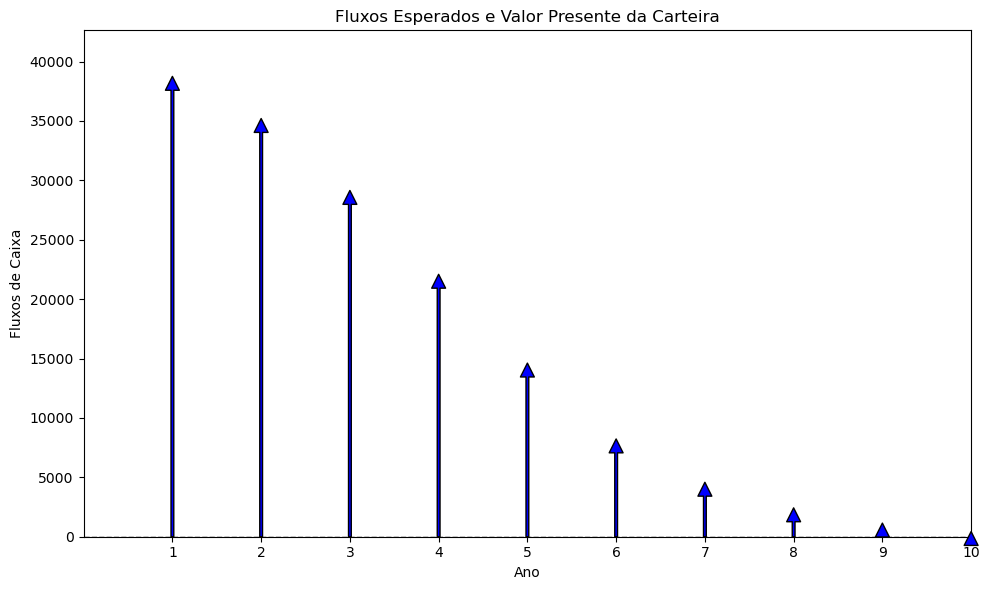

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Criar o gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar as setas para cada fluxo usando `normalized_flows`
for i, flow in enumerate(expected_cashflows):
    if flow != 0:  # Garantir que setas sejam desenhadas apenas para fluxos não nulos
        ax.annotate(
            text= "", 
            xy=(years[i], expected_cashflows[i]),  # Normalizar tamanho das setas
            xytext=(years[i], 0), 
            arrowprops=dict(
                facecolor='blue' if flow > 0 else 'red', 
                shrink=0, 
                width=2, 
                headwidth=10, 
                headlength=10,
            ),
        )

# Adicionar linha horizontal no eixo x
ax.axhline(0, color='black', linewidth=1, linestyle='--')

# Configurar o gráfico
ax.set_title("Fluxos Esperados e Valor Presente da Carteira")
ax.set_xlabel("Ano")
ax.set_ylabel("Fluxos de Caixa")
ax.set_xticks(years)
#ax.grid(True, linestyle="--", alpha=0.7)

# Aumentar o eixo y para acomodar as setas
ax.set_ylim(0, max(expected_cashflows) * 1.1)

plt.tight_layout()
plt.show()


In [ ]:
#Print dimensao de all_losses
print(np.shape(all_losses))

(1000, 10)
